<a href="https://colab.research.google.com/github/sam-ftw/dsp-multi-omics/blob/main/PTSD_multiomics_single_sample_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Outputs will be written to: /content/integration_outputs

Reading transcript file: /content/drive/MyDrive/dspDatasets/transcriptiomics_DS.csv
  > pd.read_csv(sep=None) -> shape (25373, 2)
 -> shape: (25373, 2)

Reading proteomics file: /content/drive/MyDrive/dspDatasets/proteomics_DS.csv
  > pd.read_csv(sep=None) -> shape (628, 8)
 -> shape: (628, 8)

Transcript detection -> gene column: A1BG | value column: 28
Transcript: numeric values for 25373 genes (of 25373 total rows).

Proteomics identifier column candidates: ['Names', 'Accession', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7']
Proteomics processed and saved (proteomics_processed_guess.csv).
Proteomics numeric columns detected: ['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7']
Using proteomics numeric column: Unnamed: 3
Number of genes present in both transc

2025-10-30 04:44:26,607 [WARNING] Input library not found: GO_Biological_Process_2018. Skip


ssGSEA complete. Scores saved to: /content/integration_outputs/ssgsea_scores_single_sample.csv
ssGSEA failed: no numeric data to plot
If this fails, ensure gseapy is installed and that you have internet access to fetch gene sets.

Running Enrichr on top 500 expressed genes using KEGG and GO BP (Enrichr libs).
Enrichr results saved to output directory.

=== Summary of outputs written to /content/integration_outputs ===

 - KEGG_2016.Human.enrichr.reports.pdf
 - KEGG_2016.Human.enrichr.reports.txt
 - enrichr_results.csv
 - gene_sets.gmt
 - gseapy.gene_set.ssgsea.report.csv
 - matched_transcript_proteomics_simple_mapping.csv
 - proteomics_processed_guess.csv
 - proteomics_raw_parsed.csv
 - ssgsea_scores_single_sample.csv
 - transcript_expression_single_sample.csv
 - transcript_raw_parsed.csv

Primary outputs (examples):
 - transcript_expression_single_sample.csv   (gene x 1 sample expression)
 - proteomics_processed_guess.csv            (proteomics annotations + gene guesses)
 - matched_t

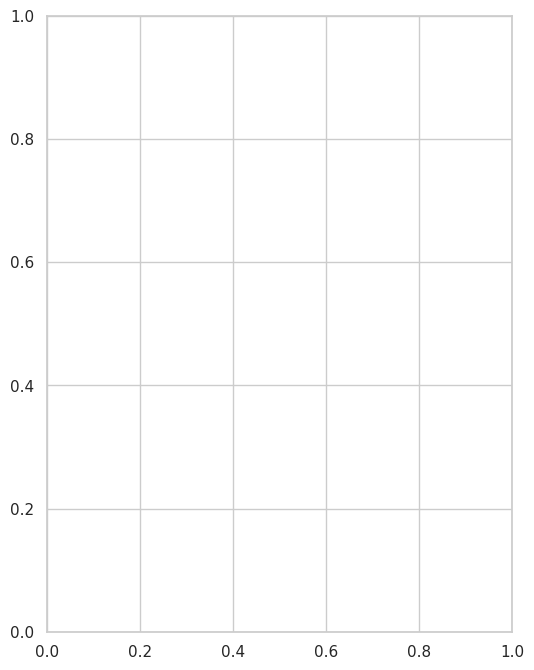

In [ ]:

!pip install gseapy --quiet

# 1) Imports and user-editable paths
import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import warnings
warnings.filterwarnings("ignore")

import gseapy as gp
from scipy.stats import pearsonr, spearmanr

from google.colab import drive
drive.mount('/content/drive')

TRANS_PATH = "/content/drive/MyDrive/dspDatasets/transcriptiomics_DS.csv"
PROT_PATH  = "/content/drive/MyDrive/dspDatasets/proteomics_DS.csv"

OUT_DIR = "/content/integration_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
print("Outputs will be written to:", OUT_DIR)

# 2) Flexible readers (handles many simple variants)
def flexible_read(path):
    """
    Read CSV/TSV flexibly. Returns dataframe and read-log messages.
    """
    log = []
    path = str(path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    try:
        df = pd.read_csv(path, sep=None, engine='python')
        log.append(f"pd.read_csv(sep=None) -> shape {df.shape}")
    except Exception as e:
        log.append(f"pd.read_csv auto failed: {e}")

        df = pd.read_csv(path, header=None)
        log.append(f"pd.read_csv(header=None) -> shape {df.shape}")

    if df.shape[1] == 1:
        s = df.iloc[:,0].astype(str)
        if s.str.contains("\t").any():
            split = s.str.split("\t", expand=True)
            split.columns = [f"col{i}" for i in range(split.shape[1])]
            df = split
            log.append(f"Single-column split by TAB -> new shape {df.shape}")
        elif s.str.contains(",").any():
            split = s.str.split(",", expand=True)
            split.columns = [f"col{i}" for i in range(split.shape[1])]
            df = split
            log.append(f"Single-column split by COMMA -> new shape {df.shape}")
    return df, log

# 3) Read the two files
print("\nReading transcript file:", TRANS_PATH)
df_trans_raw, log_t = flexible_read(TRANS_PATH)
for l in log_t: print("  >", l)
print(" -> shape:", df_trans_raw.shape)

print("\nReading proteomics file:", PROT_PATH)
df_prot_raw, log_p = flexible_read(PROT_PATH)
for l in log_p: print("  >", l)
print(" -> shape:", df_prot_raw.shape)

# Save raw copies for inspection
df_trans_raw.to_csv(os.path.join(OUT_DIR, "transcript_raw_parsed.csv"), index=False)
df_prot_raw.to_csv(os.path.join(OUT_DIR, "proteomics_raw_parsed.csv"), index=False)

# 4) Heuristics: detect which column is gene (string) and which is numeric (value) in the transcript file
def identify_gene_value_columns(df):
    # returns (gene_col, value_col) or (None, None) if not found
    nrows, ncols = df.shape
    # For each column, compute fraction numeric parsable
    frac_numeric = {}
    for c in df.columns:
        s = pd.to_numeric(df[c], errors='coerce')
        frac_numeric[c] = s.notna().mean()
    # candidate value_col = column with highest frac_numeric
    value_col = max(frac_numeric, key=lambda k: frac_numeric[k])
    # candidate gene_col = column with lowest frac_numeric (likely strings)
    gene_col = min(frac_numeric, key=lambda k: frac_numeric[k])
    # but if there's a clear pair (value fraction > 0.5 and gene fraction < 0.5), accept it
    if frac_numeric[value_col] >= 0.2 and frac_numeric[gene_col] <= 0.8 and value_col != gene_col:
        return gene_col, value_col
    # fallback: if 2 columns, assume [0]=gene, [1]=value
    if ncols == 2:
        return df.columns[0], df.columns[1]
    # otherwise try to find an obviously string column and an obviously numeric column
    num_cols = [c for c,v in frac_numeric.items() if v > 0.5]
    str_cols = [c for c,v in frac_numeric.items() if v <= 0.5]
    if num_cols and str_cols:
        return str_cols[0], num_cols[0]
    return None, None

gene_col, value_col = identify_gene_value_columns(df_trans_raw)
print("\nTranscript detection -> gene column:", gene_col, "| value column:", value_col)
if gene_col is None:
    raise ValueError("Could not detect gene/value columns in the transcript file. Please check the file format.")

# Build a cleaned transcript DataFrame: index = gene, column = sample_name
sample_name = Path(TRANS_PATH).stem
df_trans = df_trans_raw.copy()
df_trans = df_trans.rename(columns={gene_col: "gene_raw", value_col: "value_raw"})
df_trans["gene"] = df_trans["gene_raw"].astype(str).str.strip()
df_trans["value_numeric"] = pd.to_numeric(df_trans["value_raw"], errors='coerce')
# Keep only gene and numeric value
expr_series = df_trans.set_index("gene")["value_numeric"]
expr = expr_series.rename(sample_name).to_frame()  # DataFrame with index=gene, column=sample_name
expr.index = expr.index.map(lambda s: re.sub(r'[^A-Za-z0-9\-]', '', str(s)).upper())
expr = expr[~expr.index.duplicated(keep='first')]  # drop duplicated gene names if any
print(f"Transcript: numeric values for {expr[sample_name].notna().sum()} genes (of {len(expr)} total rows).")
expr.to_csv(os.path.join(OUT_DIR, "transcript_expression_single_sample.csv"))

# 5) Proteomics: try to extract a guessed gene/protein symbol from common columns
prot = df_prot_raw.copy()
# find likely identifier columns
id_candidates = [c for c in prot.columns if re.search(r'Name|Gene|Accession|Protein', c, re.IGNORECASE)]
print("\nProteomics identifier column candidates:", id_candidates)
# Create a guessed gene column by checking typical cols
prot["accession_raw"] = None
if "Accession" in prot.columns:
    prot["accession_raw"] = prot["Accession"].astype(str)
elif "Accession.1" in prot.columns:
    prot["accession_raw"] = prot["Accession.1"].astype(str)
elif "Names" in prot.columns:
    prot["accession_raw"] = prot["Names"].astype(str)
else:
    # fallback: take first string-like column
    for c in prot.columns:
        if prot[c].dtype == object:
            prot["accession_raw"] = prot[c].astype(str)
            break

# Heuristic function to extract a gene-like token from accession (UNIPROT style or NAME style)
def guess_gene_from_accession(x):
    if pd.isna(x): return None
    s = str(x)
    # if pipe '|' separated (e.g., sp|P12345|GENE_HUMAN), take last token then split on '_' or '-' to get GENE
    if '|' in s:
        last = s.split('|')[-1]
        token = last.split('_')[0]
        return re.sub(r'[^A-Za-z0-9]', '', token).upper()
    # if underscores or spaces, take first token
    token = re.split(r'[_\s\-]', s)[0]
    token = re.sub(r'[^A-Za-z0-9]', '', token).upper()
    return token if token else None

prot["protein_gene_guess"] = prot["accession_raw"].apply(guess_gene_from_accession)
prot["protein_gene_guess"] = prot["protein_gene_guess"].replace({"": None})
prot.to_csv(os.path.join(OUT_DIR, "proteomics_processed_guess.csv"), index=False)
print("Proteomics processed and saved (proteomics_processed_guess.csv).")

# Check if proteomics file contains numeric abundance columns: choose most numeric column(s) if present
numeric_cols = [c for c in prot.columns if np.issubdtype(prot[c].dtype, np.number)]
print("Proteomics numeric columns detected:", numeric_cols)
prot_abundance_col = None
if len(numeric_cols) >= 1:
    # pick the numeric column with most non-NA values
    prot_abundance_col = sorted(numeric_cols, key=lambda c: prot[c].notna().sum(), reverse=True)[0]
    print("Using proteomics numeric column:", prot_abundance_col)
else:
    print("No numeric proteomics abundance columns were detected. Correlation will only run if abundance data is present.")

# 6) Map transcript genes <-> proteomics guesses
# Prepare cleaned transcript gene set
trans_genes = expr.index.astype(str).str.upper().tolist()
prot_map = prot.copy()
prot_map["protein_gene_guess_clean"] = prot_map["protein_gene_guess"].astype(str).str.upper().str.replace(r'[^A-Z0-9]','',regex=True)
trans_clean = expr.copy()
trans_clean.index = trans_clean.index.astype(str).str.upper().str.replace(r'[^A-Z0-9]','',regex=True)

# inner join of transcripts (index) and proteomics guesses
prot_map_indexed = prot_map.set_index("protein_gene_guess_clean")
common_genes = sorted(set(trans_clean.index).intersection(set(prot_map_indexed.index)))
print(f"Number of genes present in both transcript list and proteomics guesses (by simple heuristic): {len(common_genes)}")

# Build matched table
matched_rows = []
for g in common_genes:
    tval = trans_clean.loc[g].iloc[0] if g in trans_clean.index else np.nan
    prot_row = prot_map_indexed.loc[g]
    # prot_row may be multiple rows; handle
    if isinstance(prot_row, pd.DataFrame):
        for _, prow in prot_row.iterrows():
            aval = prow[prot_abundance_col] if prot_abundance_col is not None else np.nan
            matched_rows.append({
                "gene": g,
                "transcript_value": float(tval) if not pd.isna(tval) else np.nan,
                "protein_abundance": float(aval) if not pd.isna(aval) else np.nan,
                "prot_annotation_row": prow.to_json()
            })
    else:
        aval = prot_row[prot_abundance_col] if prot_abundance_col is not None else np.nan
        matched_rows.append({
            "gene": g,
            "transcript_value": float(tval) if not pd.isna(tval) else np.nan,
            "protein_abundance": float(aval) if not pd.isna(aval) else np.nan,
            "prot_annotation_row": prot_row.to_json()
        })

matched_df = pd.DataFrame(matched_rows)
matched_df.to_csv(os.path.join(OUT_DIR, "matched_transcript_proteomics_simple_mapping.csv"), index=False)
print("Saved matched transcript-proteomics table (heuristic): matched_transcript_proteomics_simple_mapping.csv")

# 7) Correlation analysis (mRNA vs protein across genes) — valid for single sample across many genes
# This is meaningful when we have numeric proteomics abundances AND transcript values for the same genes.
if "protein_abundance" in matched_df.columns and matched_df["protein_abundance"].notna().sum() > 0 and matched_df["transcript_value"].notna().sum() > 0:
    corr_df = matched_df.dropna(subset=["transcript_value","protein_abundance"]).copy()
    x = corr_df["transcript_value"].values
    y = corr_df["protein_abundance"].values
    # If values are strongly skewed and non-negative, log1p transform for visualization
    do_log = (x.min() >= 0) and (y.min() >= 0)
    if do_log:
        lx = np.log1p(x); ly = np.log1p(y)
    else:
        lx = x; ly = y
    # compute Pearson and Spearman
    pearson_r, pearson_p = pearsonr(lx, ly)
    spearman_r, spearman_p = spearmanr(lx, ly)
    print(f"\nCorrelation (across {len(lx)} matched genes): Pearson r = {pearson_r:.4f} (p={pearson_p:.2e}), Spearman rho = {spearman_r:.4f} (p={spearman_p:.2e})")

    # Scatter plot
    plt.figure(figsize=(6,5))
    plt.scatter(lx, ly, s=18, alpha=0.6)
    plt.xlabel("Transcript (log1p)" if do_log else "Transcript")
    plt.ylabel("Protein (log1p)" if do_log else "Protein")
    plt.title(f"mRNA vs Protein (n={len(lx)}): Pearson r={pearson_r:.3f}")
    # annotate top correlated points by absolute difference in rank or by value
    # annotate top 8 by product of ranks
    corr_df["rank_prod"] = corr_df["transcript_value"].rank(ascending=False) * corr_df["protein_abundance"].rank(ascending=False)
    topN = corr_df.sort_values("rank_prod", ascending=False).head(8)
    for _, row in topN.iterrows():
        tx = np.log1p(row["transcript_value"]) if do_log else row["transcript_value"]
        py = np.log1p(row["protein_abundance"]) if do_log else row["protein_abundance"]
        plt.text(tx, py, row["gene"], fontsize=8)
    outplot = os.path.join(OUT_DIR, "mRNA_vs_protein_scatter.png")
    plt.tight_layout()
    plt.savefig(outplot, dpi=150)
    print("Saved scatter plot to:", outplot)
    plt.close()
else:
    print("\nSkipping correlation plot: either no proteomics numeric abundance column found or no overlapping numeric values between transcript and proteomics.")

# 8) Single-sample GSEA (ssGSEA) using gseapy
# We will run ssGSEA on the transcript single-sample expression vector.
# You can change the gene set library below (Enrichr library names). Common choices: 'KEGG_2016', 'GO_Biological_Process_2018', 'MSigDB_Hallmark_2020' (requires msigdb)
GS_LIB = "KEGG_2016"   # change if you prefer another Enrichr library
print("\nRunning ssGSEA using gene set library:", GS_LIB)

# gseapy expects a DataFrame with genes as index and samples as columns
expr_for_gsea = expr.copy()
# drop NA genes
expr_for_gsea = expr_for_gsea[expr_for_gsea.iloc[:,0].notna()]
print("ssGSEA input shape (genes x samples):", expr_for_gsea.shape)
# If there are very few genes, ssGSEA may fail; we guard with try/except
try:
    ss = gp.ssgsea(data=expr_for_gsea,
                   gene_sets=GS_LIB,
                   outdir=OUT_DIR,
                   sample_norm_method='rank',
                   no_plot=True,
                   processes=2, # adjust based on runtime environment
                   permutation_num=0)
    # ss.res2d is a DataFrame of enrichment scores
    ssgsea_scores = ss.res2d
    ssgsea_scores.to_csv(os.path.join(OUT_DIR, "ssgsea_scores_single_sample.csv"))
    print("ssGSEA complete. Scores saved to:", os.path.join(OUT_DIR, "ssgsea_scores_single_sample.csv"))
    # Save a small barplot of top pathways
    top_pathways = ssgsea_scores.iloc[:,0].sort_values(ascending=False).head(20)
    plt.figure(figsize=(6,8))
    top_pathways.plot.barh()
    plt.gca().invert_yaxis()
    plt.title("Top ssGSEA pathway scores (top 20)")
    plt.xlabel("ssGSEA score")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "ssgsea_top20_bar.png"), dpi=150)
    plt.close()
    print("Saved top-20 ssGSEA barplot.")
except Exception as e:
    print("ssGSEA failed:", str(e))
    print("If this fails, ensure gseapy is installed and that you have internet access to fetch gene sets.")

# 9) Enrichr over-representation test on top expressed genes (simple gene-list enrichment)
# Pick top N expressed genes from transcript (non-NA)
TOPN = 500
avail_genes = expr_for_gsea.iloc[:,0].dropna().sort_values(ascending=False)
if len(avail_genes) == 0:
    print("\nNo numeric transcript values available for Enrichr enrichment.")
else:
    topN = min(TOPN, len(avail_genes))
    top_genes_list = avail_genes.head(topN).index.tolist()
    print(f"\nRunning Enrichr on top {topN} expressed genes using KEGG and GO BP (Enrichr libs).")
    try:
        enr = gp.enrichr(gene_list=top_genes_list,
                         gene_sets=['KEGG_2016','GO_Biological_Process_2018'],
                         organism='Human', # change if your data is from another species
                         outdir=OUT_DIR,
                         cutoff=0.5 # unadjusted p-value or combined score cutoff for writing results
                        )
        # Save Enrichr results: enr.results is a dict-like or DataFrame depending on gseapy version
        try:
            # gseapy sometimes stores DataFrame at enr.results (single DF) or enr.results[lib] for each lib
            if hasattr(enr, 'results') and isinstance(enr.results, dict):
                for lib, df in enr.results.items():
                    df.to_csv(os.path.join(OUT_DIR, f"enrichr_{lib.replace(' ','_')}.csv"), index=False)
            elif hasattr(enr, 'results'):
                enr.results.to_csv(os.path.join(OUT_DIR, "enrichr_results.csv"), index=False)
            elif hasattr(enr, 'res2d'):
                enr.res2d.to_csv(os.path.join(OUT_DIR, "enrichr_res2d.csv"), index=False)
            print("Enrichr results saved to output directory.")
        except Exception:
            print("Enrichr completed but saving results failed (unexpected format). Inspect 'enr' object in the notebook.")
    except Exception as e:
        print("Enrichr failed:", str(e))
        print("Ensure internet access in Colab and that 'gseapy' supports Enrichr in your version.")

# 10) Final summary & list outputs
print("\n=== Summary of outputs written to", OUT_DIR, "===\n")
for f in sorted(os.listdir(OUT_DIR)):
    print(" -", f)

print("\nPrimary outputs (examples):")
print(" - transcript_expression_single_sample.csv   (gene x 1 sample expression)")
print(" - proteomics_processed_guess.csv            (proteomics annotations + gene guesses)")
print(" - matched_transcript_proteomics_simple_mapping.csv  (gene-level matches)")
print(" - matched scatter plot (if numeric prot abundances found): mRNA_vs_protein_scatter.png")
print(" - ssGSEA scores: ssgsea_scores_single_sample.csv (if ssGSEA succeeded)")
print(" - Enrichr results: enrichr_*.csv (if enrichment succeeded)\n")

print("If you need the outputs saved to /mnt/data instead of /content, re-run and change OUT_DIR to '/mnt/data/integration_outputs'.")

